In [ ]:
!spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180945 sha256=e87acab0d9fe8add961f835d2e822ed38ffbb08e79da2a49548cff05cc21477a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jwvveyec/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/spacy/__main__.py", line 33, in <module>
    plac.call(commands[command], sys.argv[1:])
  File "/usr/local/lib/python3.7/dist-packages/plac_core.py", line 367, in call
    cmd, result = parser.consume(arglist)
  File "/usr/local/lib/python3.7/dist-packages/plac_core.py", line 232, in consume
    return cmd, self.func(*(args + varargs + extraop

In [ ]:
!pip install gensim==3.8.1

     |████████████████████████████████| 24.2MB 179kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import gensim
import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import mean_squared_error as mse
from tqdm.notebook import tqdm
from gensim.parsing.preprocessing import (
    preprocess_string,
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric
)
import sys
from glob import glob
from gensim import utils
import os

import argparse
import en_core_web_lg
import re
import spacy
import sys
from time import time

from typing import List, Optional
from gensim.models.word2vec import Word2Vec

import logging

from gensim.test.utils import datapath

# Препроцессинг всех данных

In [ ]:
!spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180945 sha256=b433387789d73cf82b959d083f16b03f188cb374199c5505d76c860184d6797b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1lxs4w98/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import argparse
import en_core_web_lg
import re
import spacy
import sys

from typing import List, Optional


spacy_pos = {'PRON': 'HE', 'NUM': 'NUMBER'}
spacy_ent2word = {
    'CARDINAL': 'NUMBER',
    'DATE': 'DATE',
    'EVENT': 'EVENT',
    'FAC': 'FACILITY',
    'GPE': 'COUNTRY',
    'LANGUAGE': 'LANGUAGE',
    'LAW': 'LAW',
    'LOC': 'LOCATION',
    'MONEY': 'MONEY',
    'NORP': 'NATION',
    'ORDINAL': 'FIRST',
    'ORG': 'COMPANY',
    'PERCENT': 'PERCENT',
    'PERSON': 'PERSON',
    'PRODUCT': 'PRODUCT',
    'QUANTITY': 'QUANTITY',
    'TIME': 'TIME',
    'WORK_OF_ART': 'ART',
}


def decontracted(phrase: str, sentence_splitter: Optional[object] = None) -> str:
    # if sentence_splitter is None:
    #     # source: https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences
    #     sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')

    # specific
    phrase = re.sub(r"won['’‘`]t", "will not", phrase)
    phrase = re.sub(r"can['’‘`]t", "can not", phrase)
    phrase = re.sub(r"ain['’‘`]t", "am not", phrase)

    # general
    phrase = re.sub(r"n['’‘`]t", " not", phrase)
    phrase = re.sub(r"['’‘`]re", " are", phrase)
    phrase = re.sub(r"['’‘`]s", " is", phrase)  # "my mother's eyes"?
    phrase = re.sub(r"['’‘`]d", " would", phrase)
    phrase = re.sub(r"['’‘`]ll", " will", phrase)
    phrase = re.sub(r"['’‘`]t", " not", phrase)  # ?
    phrase = re.sub(r"['’‘`]ve", " have", phrase)
    phrase = re.sub(r"['’‘`]m", " am", phrase)

    phrase = re.sub(r'[^\w.?!;]', ' ', phrase)	
    phrase = re.sub(' +', ' ', phrase)

    # return re.sub(r'(?<!\w\.\w.)(?<=\.|\?|\!\;)\s', '\n', phrase)  # source: https://stackoverflow.com/questions/25735644/python-regex-for-splitting-text-into-sentences-sentence-tokenizing
    # sentences = sentence_splitter.tokenize(phrase.strip())
    sentences = re.split('[.;!?]\s*', phrase)
    return '\n'.join([sentence.strip() for sentence in sentences if sentence.strip()])


def preprocess_english_text(text: str, nlp: Optional[object] = None) -> str:
    """
    Препроцессинг текста на английском: заменяет в тексте Named Entity и pronouns (см. словари)
    Текст склеивается несколько строк через \n (одна строка на предложение)
    """
    if nlp is None:
        nlp = en_core_web_lg.load(disable=['parser'])
        nlp.max_length = 5000000

    decontracted_text = decontracted(text)
    decontracted_sentences = decontracted_text.split('\n')

    preprocessed_sentences = []
    for sentence in decontracted_sentences[:2000]:
        # print(f'sentence "{sentence}"')
        nlp_sentence = nlp(sentence)

        preprocessed_words = []
        for token in nlp_sentence:
            # print('\t', token, token.text, token.pos_, token.lemma_, token.ent_type_)
            if token.ent_type_ != '':
                preprocessed_words.append(token.text)
                continue
            if token.pos_ == 'PUNCT':
                continue

            preprocessed_word = token.text
            if token.pos_ in spacy_pos:
                preprocessed_word = spacy_pos[token.pos_]
            elif token.lemma_[1:-1] in spacy_pos:  # например, "my" -> "-PRON-"
                preprocessed_word = spacy_pos[token.lemma_[1:-1]]
            else:
                if not token.lemma_.islower() and token.pos_ != 'SPACE':
                    pass
                    # print('english preprocessing warning: token.lemma_ has upper case --- ', token, token.lemma_, token.pos_, file=sys.stderr)
                preprocessed_word = token.lemma_.lower()
            preprocessed_words.append(preprocessed_word)

        preprocessed_sentence = ' '.join(preprocessed_words)

        sorted_ents = sorted(nlp_sentence.ents, key=len, reverse=True)
        for ent in sorted_ents:
            # print('entity found:', ent.text, ent.label_)
            preprocessed_sentence = preprocessed_sentence.replace(' ' + ent.text + ' ', ' ' + spacy_ent2word[ent.label_] + ' ')

        preprocessed_sentence = re.sub(r'\s\s+', ' ', preprocessed_sentence)
        preprocessed_sentences.append(preprocessed_sentence.strip())

    return '\n'.join(preprocessed_sentences)

In [ ]:
    # nlp = en_core_web_lg.load(disable=['parser'])
    # nlp.max_length = 5000000

    for filename in tqdm(glob('drive/MyDrive/Coursework2021/EnLit/*/*/*.txt')):
        with open(filename, 'r') as f:
            preprocessed_text = preprocess_english_text(f.read(), nlp)
        target_filename = filename.replace('EnLit', 'EnLitPreprocessed')
        os.makedirs(os.path.dirname(target_filename), exist_ok=True)
        with open(target_filename, 'w') as f:
            f.write(preprocessed_text)

KeyboardInterrupt: ignored

In [ ]:
with open('drive/MyDrive/Coursework2021/english_corpus.txt', 'r') as f:
    i = 0
    for sent in f:
        if i == 20:
            break
        print(sent)
        i += 1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Обучение CBOW

In [ ]:
class PreprocessedCorpus:
    SENTENCE_SIZE = 32
    """Генерация корпуса из предобработанных текстов"""
    def __iter__(self):
        with open('drive/MyDrive/Coursework2021/english_corpus.txt', 'r') as f:
            for text in f:
                words = text.split()
                for i in range(0, len(words), self.SENTENCE_SIZE):
                    yield ' '.join(words[i:i + self.SENTENCE_SIZE])

In [ ]:
corpus = PreprocessedCorpus()

with open('drive/MyDrive/Coursework2021/english_corpus_sentences.txt', 'w') as f:
    for sentence in tqdm(corpus):
        f.write(sentence)
        f.write('\n')

In [ ]:
!head -10 drive/MyDrive/Coursework2021/english_corpus_sentences.txt

chapter and maiden call -PRON- love in idleness TIME1 be dream there be none of GPE1 be daughter that bear a proud presence and a kingly blood send glance up -PRON- princely
eye to trouble and the shadow of a monarch be crown be soften in -PRON- hair PERSON1 PERSON1 the sun shine slant over a spacious park the undulating ground here turn a
broad lawn towards the beam that silver every blade of grass there curve away in bank of velvet green shadow by the tree gnarl old thorn in the holiday suit whence -PRON-
take -PRON- name giant be nosegay of horse chestnut mighty elm and stalwart oak singly or in group the aristocracy of the place while in the background rise wooded covert where every
tint of early green blend in rich masse of varied foliage an FAC1 QUANTITY1 in length consist of a quadruple range of splendid lime tree of uniform growth the side arcade vault
over by the meeting branch and the central road where the same light and shadow be again and again repeat conduct the eye in di

In [ ]:
from gensim.models.word2vec import Word2Vec

# sentences = PreprocessedCorpus()
# model = Word2Vec(sentences=sentences, size=30, window=5, min_count=5, iter=3, compute_loss=True, sg=0)

In [ ]:
w2v_model = Word2Vec(
    min_count=5,
    window=5,
    size=30,
    workers=3,
    sg=0
)

In [ ]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

t = time()

w2v_model.build_vocab(corpus_file='drive/MyDrive/Coursework2021/english_corpus_sentences.txt', progress_per=100_000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:25:48: collecting all words and their counts
INFO - 17:25:48: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:25:49: PROGRESS: at sentence #100000, processed 3199467 words, keeping 31038 word types
INFO - 17:25:50: PROGRESS: at sentence #200000, processed 6393424 words, keeping 46350 word types
INFO - 17:25:51: PROGRESS: at sentence #300000, processed 9592206 words, keeping 56370 word types
INFO - 17:25:52: PROGRESS: at sentence #400000, processed 12790365 words, keeping 61304 word types
INFO - 17:25:53: PROGRESS: at sentence #500000, processed 15987247 words, keeping 67621 word types
INFO - 17:25:55: PROGRESS: at sentence #600000, processed 19185947 words, keeping 74681 word types
INFO - 17:25:56: PROGRESS: at sentence #700000, processed 22384625 words, keeping 78495 word types
INFO - 17:25:57: PROGRESS: at sentence #800000, processed 25581035 words, keeping 83540 word types
INFO - 17:25:58: PROGRESS: at sentence #900000, processed 28779894 words,

Time to build vocab: 1.8 mins


In [ ]:
t = time()

w2v_model.train(corpus_file='drive/MyDrive/Coursework2021/english_corpus_sentences.txt', total_words=w2v_model.corpus_count, epochs=10, report_delay=1, compute_loss=True)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:48:05: training model with 3 workers on 112779 vocabulary and 30 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 17:48:16: EPOCH 1 - PROGRESS: at 33.34% words, 148870 words/s, in_qsize -1, out_qsize 1
INFO - 17:48:16: worker thread finished; awaiting finish of 2 more threads
INFO - 17:48:17: worker thread finished; awaiting finish of 1 more threads
INFO - 17:48:17: worker thread finished; awaiting finish of 0 more threads
INFO - 17:48:17: EPOCH - 1 : training on 7331796 raw words (4785621 effective words) took 11.4s, 419489 effective words/s
INFO - 17:48:28: EPOCH 2 - PROGRESS: at 33.34% words, 143923 words/s, in_qsize -1, out_qsize 1
INFO - 17:48:28: worker thread finished; awaiting finish of 2 more threads
INFO - 17:48:28: worker thread finished; awaiting finish of 1 more threads
INFO - 17:48:28: worker thread finished; awaiting finish of 0 more threads
INFO - 17:48:28: EPOCH - 2 : training on 7331796 raw words (4786064 effective words) took 11.3s, 422760 

Time to train the model: 1.92 mins


In [ ]:
w2v_model.wv.most_similar(positive=["king", "woman"], negative=["queen"], topn=5)

[('man', 0.9054774045944214),
 ('rogue', 0.8044534921646118),
 ('soldier', 0.7816331386566162),
 ('lad', 0.7517293691635132),
 ('vagabond', 0.741921067237854)]

In [ ]:
w2v_model.wv.most_similar('father')

[('mother', 0.8626376390457153),
 ('husband', 0.8381612300872803),
 ('brother', 0.8210199475288391),
 ('son', 0.8139342665672302),
 ('daughter', 0.8087155818939209),
 ('uncle', 0.7751367688179016),
 ('wife', 0.7745674848556519),
 ('philippe', 0.7727748155593872),
 ('jesus', 0.7217352390289307),
 ('prodigal', 0.7121433615684509)]

In [ ]:
from gensim.test.utils import datapath

w2v_model.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

INFO - 17:50:01: Pearson correlation coefficient against /usr/local/lib/python3.7/dist-packages/gensim/test/test_data/wordsim353.tsv: 0.2945
INFO - 17:50:01: Spearman rank-order correlation coefficient against /usr/local/lib/python3.7/dist-packages/gensim/test/test_data/wordsim353.tsv: 0.2655
INFO - 17:50:01: Pairs with unknown words ratio: 7.1%


((0.2945319630053474, 5.483825739250601e-08),
 SpearmanrResult(correlation=0.2655422268212068, pvalue=1.067993770791334e-06),
 7.0821529745042495)

In [ ]:
w2v_model.wv.save_word2vec_format('drive/MyDrive/Coursework2021/cbow/5_5_30.kv')

INFO - 19:01:53: storing 112779x30 projection weights into drive/MyDrive/Coursework2021/cbow/5_5_30.kv


# Ненормализованный текст и w2v

In [ ]:
def decontracted(phrase: str, sentence_splitter: Optional[object] = None) -> str:
    # if sentence_splitter is None:
    #     # source: https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences
    #     sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')

    # specific
    phrase = re.sub(r"won['’‘`]t", "will not", phrase)
    phrase = re.sub(r"can['’‘`]t", "can not", phrase)
    phrase = re.sub(r"ain['’‘`]t", "am not", phrase)

    # general
    phrase = re.sub(r"n['’‘`]t", " not", phrase)
    phrase = re.sub(r"['’‘`]re", " are", phrase)
    phrase = re.sub(r"['’‘`]s", " is", phrase)  # "my mother's eyes"?
    phrase = re.sub(r"['’‘`]d", " would", phrase)
    phrase = re.sub(r"['’‘`]ll", " will", phrase)
    phrase = re.sub(r"['’‘`]t", " not", phrase)  # ?
    phrase = re.sub(r"['’‘`]ve", " have", phrase)
    phrase = re.sub(r"['’‘`]m", " am", phrase)

    phrase = re.sub(r'[^\w.?!;]', ' ', phrase)	
    phrase = re.sub(' +', ' ', phrase)

    # return re.sub(r'(?<!\w\.\w.)(?<=\.|\?|\!\;)\s', '\n', phrase)  # source: https://stackoverflow.com/questions/25735644/python-regex-for-splitting-text-into-sentences-sentence-tokenizing
    # sentences = sentence_splitter.tokenize(phrase.strip())
    sentences = re.split('[.;!?]\s*', phrase)
    return '\n'.join([sentence.strip() for sentence in sentences if sentence.strip()])

In [ ]:
# ПОЛУНОРМАЛИЗОВАННЫЕ ТЕКСТЫ ДЕЛИМ НА ПРЕДЛОЖЕНИЯ

with open('drive/MyDrive/Coursework2021/english_corpus_unnormed_sentences.txt', 'w') as out:
    for fname in tqdm(glob('drive/MyDrive/Coursework2021/EnLit/EnLit/*/*.txt')):
        if '(Poetry)' in fname:
            continue
        with open(fname, 'r') as f:
            sents = decontracted(f.read())
        out.write(sents)
        out.write('\n')

In [ ]:
w2v_model_unnormed = Word2Vec(
    min_count=5,
    window=5,
    size=30,
    workers=3,
    sg=0
)

WARNING - 18:50:44: consider setting layer size to a multiple of 4 for greater performance


In [ ]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

t = time()

w2v_model_unnormed.build_vocab(corpus_file='drive/MyDrive/Coursework2021/english_corpus_unnormed_sentences.txt', progress_per=500_000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 18:50:45: collecting all words and their counts
INFO - 18:50:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:50:48: PROGRESS: at sentence #500000, processed 7728265 words, keeping 69081 word types
INFO - 18:50:52: PROGRESS: at sentence #1000000, processed 14972264 words, keeping 82824 word types
INFO - 18:50:56: PROGRESS: at sentence #1500000, processed 21738079 words, keeping 98650 word types
INFO - 18:51:00: PROGRESS: at sentence #2000000, processed 28908808 words, keeping 120037 word types
INFO - 18:51:04: PROGRESS: at sentence #2500000, processed 36441571 words, keeping 133407 word types
INFO - 18:51:08: PROGRESS: at sentence #3000000, processed 43364507 words, keeping 145728 word types
INFO - 18:51:12: PROGRESS: at sentence #3500000, processed 52361884 words, keeping 154102 word types
INFO - 18:51:16: PROGRESS: at sentence #4000000, processed 60282840 words, keeping 167422 word types
INFO - 18:51:20: PROGRESS: at sentence #4500000, processed 

Time to build vocab: 2.4 mins


In [ ]:
t = time()

w2v_model_unnormed.train(corpus_file='drive/MyDrive/Coursework2021/english_corpus_unnormed_sentences.txt', total_words=w2v_model_unnormed.corpus_count, epochs=10, report_delay=1, compute_loss=True)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 18:53:10: training model with 3 workers on 142898 vocabulary and 30 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 18:53:38: EPOCH 1 - PROGRESS: at 33.35% words, 141306 words/s, in_qsize -1, out_qsize 1
INFO - 18:53:38: worker thread finished; awaiting finish of 2 more threads
INFO - 18:53:39: worker thread finished; awaiting finish of 1 more threads
INFO - 18:53:39: worker thread finished; awaiting finish of 0 more threads
INFO - 18:53:39: EPOCH - 1 : training on 15890252 raw words (11679319 effective words) took 28.2s, 414121 effective words/s
INFO - 18:54:07: EPOCH 2 - PROGRESS: at 33.35% words, 140915 words/s, in_qsize -1, out_qsize 1
INFO - 18:54:07: worker thread finished; awaiting finish of 2 more threads
INFO - 18:54:07: worker thread finished; awaiting finish of 1 more threads
INFO - 18:54:07: worker thread finished; awaiting finish of 0 more threads
INFO - 18:54:07: EPOCH - 2 : training on 15890252 raw words (11677293 effective words) took 28.1s, 415

Time to train the model: 4.74 mins


In [ ]:
w2v_model_unnormed.wv.most_similar(positive=["king", "woman"], negative=["queen"], topn=3)

INFO - 18:57:58: precomputing L2-norms of word weight vectors


[('man', 0.88695228099823),
 ('englishman', 0.8178852796554565),
 ('frenchman', 0.8016090989112854)]

In [ ]:
w2v_model_unnormed.wv.most_similar('father')

[('mother', 0.9474223256111145),
 ('husband', 0.9434542059898376),
 ('brother', 0.9235114455223083),
 ('wife', 0.9211167693138123),
 ('sister', 0.9062756299972534),
 ('daughter', 0.8917903304100037),
 ('niece', 0.8882549405097961),
 ('grandfather', 0.8797966837882996),
 ('nephew', 0.8639758825302124),
 ('cousin', 0.8614261746406555)]

In [ ]:
w2v_model_unnormed.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

INFO - 18:57:59: Pearson correlation coefficient against /usr/local/lib/python3.7/dist-packages/gensim/test/test_data/wordsim353.tsv: 0.2906
INFO - 18:57:59: Spearman rank-order correlation coefficient against /usr/local/lib/python3.7/dist-packages/gensim/test/test_data/wordsim353.tsv: 0.2815
INFO - 18:57:59: Pairs with unknown words ratio: 6.8%


((0.29059856007506973, 7.997528815708047e-08),
 SpearmanrResult(correlation=0.28146888529114505, pvalue=2.088529189713924e-07),
 6.79886685552408)

In [ ]:
w2v_model_unnormed.wv.evaluate_word_analogies(datapath('questions-words.txt')[0]

INFO - 18:59:15: Evaluating word analogies for top 300000 words in the model on /usr/local/lib/python3.7/dist-packages/gensim/test/test_data/questions-words.txt
INFO - 18:59:16: capital-common-countries: 4.9% (9/182)
INFO - 18:59:19: capital-world: 0.7% (5/700)
INFO - 18:59:19: currency: 0.0% (0/154)
INFO - 18:59:27: city-in-state: 0.1% (1/1874)
INFO - 18:59:29: family: 27.9% (129/462)
INFO - 18:59:34: gram1-adjective-to-adverb: 7.6% (75/992)
INFO - 18:59:37: gram2-opposite: 1.2% (8/650)
INFO - 18:59:42: gram3-comparative: 35.1% (467/1332)
INFO - 18:59:47: gram4-superlative: 7.8% (82/1056)
INFO - 18:59:50: gram5-present-participle: 11.7% (102/870)
INFO - 18:59:55: gram6-nationality-adjective: 0.8% (8/1030)
INFO - 19:00:02: gram7-past-tense: 31.4% (466/1482)
INFO - 19:00:07: gram8-plural: 18.1% (228/1260)
INFO - 19:00:11: gram9-plural-verbs: 10.6% (92/870)
INFO - 19:00:11: Quadruplets with out-of-vocabulary words: 33.9%
INFO - 19:00:11: NB: analogies containing OOV words were skipped fr

0.12947189097103917

In [ ]:
w2v_model_unnormed.wv.save_word2vec_format('drive/MyDrive/Coursework2021/cbow/5_5_30_unnormed.kv')

INFO - 19:01:25: storing 142898x30 projection weights into drive/MyDrive/Coursework2021/cbow/5_5_30_unnormed.kv


# Обучение w2v для разных параметров

In [ ]:
def w2v_train_and_save(size, unnormed=False):
    unnormed_str = '_unnormed' if unnormed else ''
    w2v_model = Word2Vec(
        min_count=10,
        window=5,
        size=size,
        workers=3,
        sg=0
    )
    t = time()
    w2v_model.build_vocab(corpus_file='drive/MyDrive/Coursework2021/english_corpus' + unnormed_str + '_sentences.txt', progress_per=5_000_000)
    print('Time to build vocab for size {}: {} mins'.format(size, round((time() - t) / 60, 2)))
    w2v_model.train(corpus_file='drive/MyDrive/Coursework2021/english_corpus' + unnormed_str + '_sentences.txt', total_words=w2v_model.corpus_count, epochs=10, report_delay=1, compute_loss=True)
    print('Time to train the model for size {}: {} mins'.format(size, round((time() - t) / 60, 2)))
    w2v_model.wv.save_word2vec_format(f'drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size{size}' + unnormed_str + '.kv')

In [ ]:
for size in [4, 8, 16, 24, 32, 64]:
    w2v_train_and_save(size, unnormed=False)
    w2v_train_and_save(size, unnormed=True)

INFO - 19:24:11: collecting all words and their counts
INFO - 19:24:11: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:25:08: PROGRESS: at sentence #5000000, processed 159876509 words, keeping 251477 word types
INFO - 19:25:35: collected 315436 word types from a corpus of 234390533 raw words and 7330025 sentences
INFO - 19:25:35: Loading a fresh vocabulary
INFO - 19:25:35: effective_min_count=10 retains 81292 unique words (25% of original 315436, drops 234144)
INFO - 19:25:35: effective_min_count=10 leaves 233851809 word corpus (99% of original 234390533, drops 538724)
INFO - 19:25:36: deleting the raw counts dictionary of 315436 items
INFO - 19:25:36: sample=0.001 downsamples 47 most-common words
INFO - 19:25:36: downsampling leaves estimated 153836795 word corpus (65.8% of prior 233851809)
INFO - 19:25:36: estimated required memory for 81292 words and 4 dimensions: 43247344 bytes
INFO - 19:25:36: resetting layer weights
INFO - 19:25:55: training model wit

Time to build vocab for size 4: 32.75 mins


INFO - 19:26:03: EPOCH 1 - PROGRESS: at 33.34% words, 215860 words/s, in_qsize -1, out_qsize 1
INFO - 19:26:03: worker thread finished; awaiting finish of 2 more threads
INFO - 19:26:03: worker thread finished; awaiting finish of 1 more threads
INFO - 19:26:03: worker thread finished; awaiting finish of 0 more threads
INFO - 19:26:03: EPOCH - 1 : training on 7331796 raw words (4778162 effective words) took 7.7s, 624504 effective words/s
INFO - 19:26:10: EPOCH 2 - PROGRESS: at 33.34% words, 216122 words/s, in_qsize -1, out_qsize 1
INFO - 19:26:10: worker thread finished; awaiting finish of 2 more threads
INFO - 19:26:11: worker thread finished; awaiting finish of 1 more threads
INFO - 19:26:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:26:11: EPOCH - 2 : training on 7331796 raw words (4778619 effective words) took 7.6s, 630816 effective words/s
INFO - 19:26:18: EPOCH 3 - PROGRESS: at 33.34% words, 217998 words/s, in_qsize -1, out_qsize 1
INFO - 19:26:18: worker

Time to train the model for size 4: 34.03 mins


INFO - 19:27:13: collecting all words and their counts
INFO - 19:27:13: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:27:45: PROGRESS: at sentence #5000000, processed 75688780 words, keeping 197907 word types
INFO - 19:28:16: PROGRESS: at sentence #10000000, processed 145691679 words, keeping 280976 word types
INFO - 19:28:50: PROGRESS: at sentence #15000000, processed 222126692 words, keeping 380747 word types
INFO - 19:28:54: collected 386933 word types from a corpus of 232179470 raw words and 15660788 sentences
INFO - 19:28:54: Loading a fresh vocabulary
INFO - 19:28:55: effective_min_count=10 retains 103129 unique words (26% of original 386933, drops 283804)
INFO - 19:28:55: effective_min_count=10 leaves 231550302 word corpus (99% of original 232179470, drops 629168)
INFO - 19:28:55: deleting the raw counts dictionary of 386933 items
INFO - 19:28:55: sample=0.001 downsamples 52 most-common words
INFO - 19:28:55: downsampling leaves estimated 169268020 

Time to build vocab for size 4: 36.15 mins


INFO - 19:29:38: EPOCH 1 - PROGRESS: at 33.37% words, 207312 words/s, in_qsize -1, out_qsize 1
INFO - 19:29:38: worker thread finished; awaiting finish of 2 more threads
INFO - 19:29:38: worker thread finished; awaiting finish of 1 more threads
INFO - 19:29:38: worker thread finished; awaiting finish of 0 more threads
INFO - 19:29:38: EPOCH - 1 : training on 15679632 raw words (11489431 effective words) took 18.9s, 608544 effective words/s
INFO - 19:29:57: EPOCH 2 - PROGRESS: at 33.37% words, 211094 words/s, in_qsize -1, out_qsize 1
INFO - 19:29:57: worker thread finished; awaiting finish of 2 more threads
INFO - 19:29:57: worker thread finished; awaiting finish of 1 more threads
INFO - 19:29:57: worker thread finished; awaiting finish of 0 more threads
INFO - 19:29:57: EPOCH - 2 : training on 15679632 raw words (11490166 effective words) took 18.9s, 607539 effective words/s
INFO - 19:30:16: EPOCH 3 - PROGRESS: at 33.37% words, 207092 words/s, in_qsize -1, out_qsize 1
INFO - 19:30:16: 

Time to train the model for size 4: 39.34 mins


INFO - 19:32:32: collecting all words and their counts
INFO - 19:32:32: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:33:26: PROGRESS: at sentence #5000000, processed 159876509 words, keeping 251477 word types
INFO - 19:33:52: collected 315436 word types from a corpus of 234390533 raw words and 7330025 sentences
INFO - 19:33:52: Loading a fresh vocabulary
INFO - 19:33:53: effective_min_count=10 retains 81292 unique words (25% of original 315436, drops 234144)
INFO - 19:33:53: effective_min_count=10 leaves 233851809 word corpus (99% of original 234390533, drops 538724)
INFO - 19:33:53: deleting the raw counts dictionary of 315436 items
INFO - 19:33:53: sample=0.001 downsamples 47 most-common words
INFO - 19:33:53: downsampling leaves estimated 153836795 word corpus (65.8% of prior 233851809)
INFO - 19:33:53: estimated required memory for 81292 words and 8 dimensions: 45848688 bytes
INFO - 19:33:53: resetting layer weights
INFO - 19:34:12: training model wit

Time to build vocab for size 8: 41.04 mins


INFO - 19:34:21: EPOCH 1 - PROGRESS: at 33.34% words, 198553 words/s, in_qsize -1, out_qsize 1
INFO - 19:34:21: worker thread finished; awaiting finish of 2 more threads
INFO - 19:34:21: worker thread finished; awaiting finish of 1 more threads
INFO - 19:34:21: worker thread finished; awaiting finish of 0 more threads
INFO - 19:34:21: EPOCH - 1 : training on 7331796 raw words (4778162 effective words) took 8.2s, 582416 effective words/s
INFO - 19:34:29: EPOCH 2 - PROGRESS: at 33.34% words, 195176 words/s, in_qsize -1, out_qsize 1
INFO - 19:34:29: worker thread finished; awaiting finish of 2 more threads
INFO - 19:34:29: worker thread finished; awaiting finish of 1 more threads
INFO - 19:34:29: worker thread finished; awaiting finish of 0 more threads
INFO - 19:34:29: EPOCH - 2 : training on 7331796 raw words (4778619 effective words) took 8.2s, 583087 effective words/s
INFO - 19:34:37: EPOCH 3 - PROGRESS: at 33.34% words, 198130 words/s, in_qsize -1, out_qsize 1
INFO - 19:34:37: worker

Time to train the model for size 8: 42.43 mins


INFO - 19:35:37: collecting all words and their counts
INFO - 19:35:37: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:36:10: PROGRESS: at sentence #5000000, processed 75688780 words, keeping 197907 word types
INFO - 19:36:43: PROGRESS: at sentence #10000000, processed 145691679 words, keeping 280976 word types
INFO - 19:37:18: PROGRESS: at sentence #15000000, processed 222126692 words, keeping 380747 word types
INFO - 19:37:22: collected 386933 word types from a corpus of 232179470 raw words and 15660788 sentences
INFO - 19:37:22: Loading a fresh vocabulary
INFO - 19:37:23: effective_min_count=10 retains 103129 unique words (26% of original 386933, drops 283804)
INFO - 19:37:23: effective_min_count=10 leaves 231550302 word corpus (99% of original 232179470, drops 629168)
INFO - 19:37:23: deleting the raw counts dictionary of 386933 items
INFO - 19:37:23: sample=0.001 downsamples 52 most-common words
INFO - 19:37:23: downsampling leaves estimated 169268020 

Time to build vocab for size 8: 44.62 mins


INFO - 19:38:08: EPOCH 1 - PROGRESS: at 33.37% words, 187618 words/s, in_qsize -1, out_qsize 1
INFO - 19:38:08: worker thread finished; awaiting finish of 2 more threads
INFO - 19:38:08: worker thread finished; awaiting finish of 1 more threads
INFO - 19:38:08: worker thread finished; awaiting finish of 0 more threads
INFO - 19:38:08: EPOCH - 1 : training on 15679632 raw words (11489431 effective words) took 20.7s, 555753 effective words/s
INFO - 19:38:29: EPOCH 2 - PROGRESS: at 33.37% words, 192277 words/s, in_qsize -1, out_qsize 1
INFO - 19:38:29: worker thread finished; awaiting finish of 2 more threads
INFO - 19:38:29: worker thread finished; awaiting finish of 1 more threads
INFO - 19:38:29: worker thread finished; awaiting finish of 0 more threads
INFO - 19:38:29: EPOCH - 2 : training on 15679632 raw words (11490166 effective words) took 20.7s, 554003 effective words/s
INFO - 19:38:50: EPOCH 3 - PROGRESS: at 33.37% words, 190815 words/s, in_qsize -1, out_qsize 1
INFO - 19:38:50: 

Time to train the model for size 8: 48.05 mins


INFO - 19:41:15: collecting all words and their counts
INFO - 19:41:15: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:42:09: PROGRESS: at sentence #5000000, processed 159876509 words, keeping 251477 word types
INFO - 19:42:34: collected 315436 word types from a corpus of 234390533 raw words and 7330025 sentences
INFO - 19:42:34: Loading a fresh vocabulary
INFO - 19:42:35: effective_min_count=10 retains 81292 unique words (25% of original 315436, drops 234144)
INFO - 19:42:35: effective_min_count=10 leaves 233851809 word corpus (99% of original 234390533, drops 538724)
INFO - 19:42:35: deleting the raw counts dictionary of 315436 items
INFO - 19:42:35: sample=0.001 downsamples 47 most-common words
INFO - 19:42:35: downsampling leaves estimated 153836795 word corpus (65.8% of prior 233851809)
INFO - 19:42:35: estimated required memory for 81292 words and 16 dimensions: 51051376 bytes
INFO - 19:42:35: resetting layer weights
INFO - 19:42:54: training model wi

Time to build vocab for size 16: 49.73 mins


INFO - 19:43:03: EPOCH 1 - PROGRESS: at 33.34% words, 186328 words/s, in_qsize -1, out_qsize 1
INFO - 19:43:03: worker thread finished; awaiting finish of 2 more threads
INFO - 19:43:03: worker thread finished; awaiting finish of 1 more threads
INFO - 19:43:03: worker thread finished; awaiting finish of 0 more threads
INFO - 19:43:03: EPOCH - 1 : training on 7331796 raw words (4778162 effective words) took 9.2s, 521744 effective words/s
INFO - 19:43:13: EPOCH 2 - PROGRESS: at 33.34% words, 176309 words/s, in_qsize -1, out_qsize 1
INFO - 19:43:13: worker thread finished; awaiting finish of 2 more threads
INFO - 19:43:13: worker thread finished; awaiting finish of 1 more threads
INFO - 19:43:13: worker thread finished; awaiting finish of 0 more threads
INFO - 19:43:13: EPOCH - 2 : training on 7331796 raw words (4778619 effective words) took 9.2s, 518337 effective words/s
INFO - 19:43:22: EPOCH 3 - PROGRESS: at 33.34% words, 177605 words/s, in_qsize -1, out_qsize 1
INFO - 19:43:22: worker

Time to train the model for size 16: 51.27 mins


INFO - 19:44:28: collecting all words and their counts
INFO - 19:44:28: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:45:00: PROGRESS: at sentence #5000000, processed 75688780 words, keeping 197907 word types
INFO - 19:45:31: PROGRESS: at sentence #10000000, processed 145691679 words, keeping 280976 word types
INFO - 19:46:05: PROGRESS: at sentence #15000000, processed 222126692 words, keeping 380747 word types
INFO - 19:46:09: collected 386933 word types from a corpus of 232179470 raw words and 15660788 sentences
INFO - 19:46:09: Loading a fresh vocabulary
INFO - 19:46:09: effective_min_count=10 retains 103129 unique words (26% of original 386933, drops 283804)
INFO - 19:46:09: effective_min_count=10 leaves 231550302 word corpus (99% of original 232179470, drops 629168)
INFO - 19:46:10: deleting the raw counts dictionary of 386933 items
INFO - 19:46:10: sample=0.001 downsamples 52 most-common words
INFO - 19:46:10: downsampling leaves estimated 169268020 

Time to build vocab for size 16: 53.4 mins


INFO - 19:46:56: EPOCH 1 - PROGRESS: at 33.37% words, 175036 words/s, in_qsize -1, out_qsize 1
INFO - 19:46:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:46:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:46:57: worker thread finished; awaiting finish of 0 more threads
INFO - 19:46:57: EPOCH - 1 : training on 15679632 raw words (11489431 effective words) took 22.6s, 509332 effective words/s
INFO - 19:47:18: EPOCH 2 - PROGRESS: at 33.37% words, 178439 words/s, in_qsize -1, out_qsize 1
INFO - 19:47:18: worker thread finished; awaiting finish of 2 more threads
INFO - 19:47:19: EPOCH 2 - PROGRESS: at 66.75% words, 341587 words/s, in_qsize -1, out_qsize 1
INFO - 19:47:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:47:20: worker thread finished; awaiting finish of 0 more threads
INFO - 19:47:20: EPOCH - 2 : training on 15679632 raw words (11490166 effective words) took 22.5s, 510600 effective words/s
INFO - 19:47:42: 

Time to train the model for size 16: 57.2 mins


INFO - 19:50:24: collecting all words and their counts
INFO - 19:50:24: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:51:18: PROGRESS: at sentence #5000000, processed 159876509 words, keeping 251477 word types
INFO - 19:51:43: collected 315436 word types from a corpus of 234390533 raw words and 7330025 sentences
INFO - 19:51:43: Loading a fresh vocabulary
INFO - 19:51:44: effective_min_count=10 retains 81292 unique words (25% of original 315436, drops 234144)
INFO - 19:51:44: effective_min_count=10 leaves 233851809 word corpus (99% of original 234390533, drops 538724)
INFO - 19:51:44: deleting the raw counts dictionary of 315436 items
INFO - 19:51:44: sample=0.001 downsamples 47 most-common words
INFO - 19:51:44: downsampling leaves estimated 153836795 word corpus (65.8% of prior 233851809)
INFO - 19:51:44: estimated required memory for 81292 words and 24 dimensions: 56254064 bytes
INFO - 19:51:44: resetting layer weights
INFO - 19:52:03: training model wi

Time to build vocab for size 24: 58.89 mins


INFO - 19:52:13: EPOCH 1 - PROGRESS: at 33.34% words, 161929 words/s, in_qsize -1, out_qsize 1
INFO - 19:52:13: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:13: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:14: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:14: EPOCH - 1 : training on 7331796 raw words (4778162 effective words) took 10.2s, 467796 effective words/s
INFO - 19:52:24: EPOCH 2 - PROGRESS: at 33.34% words, 160789 words/s, in_qsize -1, out_qsize 1
INFO - 19:52:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:24: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:24: EPOCH - 2 : training on 7331796 raw words (4778619 effective words) took 10.1s, 471904 effective words/s
INFO - 19:52:34: EPOCH 3 - PROGRESS: at 33.34% words, 159306 words/s, in_qsize -1, out_qsize 1
INFO - 19:52:34: work

Time to train the model for size 24: 60.6 mins


INFO - 19:53:48: collecting all words and their counts
INFO - 19:53:48: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:54:20: PROGRESS: at sentence #5000000, processed 75688780 words, keeping 197907 word types
INFO - 19:54:52: PROGRESS: at sentence #10000000, processed 145691679 words, keeping 280976 word types
INFO - 19:55:25: PROGRESS: at sentence #15000000, processed 222126692 words, keeping 380747 word types
INFO - 19:55:29: collected 386933 word types from a corpus of 232179470 raw words and 15660788 sentences
INFO - 19:55:29: Loading a fresh vocabulary
INFO - 19:55:29: effective_min_count=10 retains 103129 unique words (26% of original 386933, drops 283804)
INFO - 19:55:29: effective_min_count=10 leaves 231550302 word corpus (99% of original 232179470, drops 629168)
INFO - 19:55:30: deleting the raw counts dictionary of 386933 items
INFO - 19:55:30: sample=0.001 downsamples 52 most-common words
INFO - 19:55:30: downsampling leaves estimated 169268020 

Time to build vocab for size 24: 62.71 mins


INFO - 19:56:18: EPOCH 1 - PROGRESS: at 33.37% words, 155019 words/s, in_qsize -1, out_qsize 1
INFO - 19:56:18: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:18: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:18: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:18: EPOCH - 1 : training on 15679632 raw words (11489431 effective words) took 25.1s, 456935 effective words/s
INFO - 19:56:43: EPOCH 2 - PROGRESS: at 33.37% words, 157196 words/s, in_qsize -1, out_qsize 1
INFO - 19:56:43: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:43: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:43: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:43: EPOCH - 2 : training on 15679632 raw words (11490166 effective words) took 24.9s, 462327 effective words/s
INFO - 19:57:08: EPOCH 3 - PROGRESS: at 33.37% words, 154444 words/s, in_qsize -1, out_qsize 1
INFO - 19:57:08: 

Time to train the model for size 24: 66.92 mins


INFO - 20:00:08: collecting all words and their counts
INFO - 20:00:08: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:01:01: PROGRESS: at sentence #5000000, processed 159876509 words, keeping 251477 word types
INFO - 20:01:26: collected 315436 word types from a corpus of 234390533 raw words and 7330025 sentences
INFO - 20:01:26: Loading a fresh vocabulary
INFO - 20:01:27: effective_min_count=10 retains 81292 unique words (25% of original 315436, drops 234144)
INFO - 20:01:27: effective_min_count=10 leaves 233851809 word corpus (99% of original 234390533, drops 538724)
INFO - 20:01:27: deleting the raw counts dictionary of 315436 items
INFO - 20:01:27: sample=0.001 downsamples 47 most-common words
INFO - 20:01:27: downsampling leaves estimated 153836795 word corpus (65.8% of prior 233851809)
INFO - 20:01:27: estimated required memory for 81292 words and 32 dimensions: 61456752 bytes
INFO - 20:01:27: resetting layer weights
INFO - 20:01:45: training model wi

Time to build vocab for size 32: 68.58 mins


INFO - 20:01:54: EPOCH 1 - PROGRESS: at 33.34% words, 192171 words/s, in_qsize -1, out_qsize 1
INFO - 20:01:54: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:54: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:54: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:54: EPOCH - 1 : training on 7331796 raw words (4778162 effective words) took 8.6s, 555002 effective words/s
INFO - 20:02:02: EPOCH 2 - PROGRESS: at 33.34% words, 190825 words/s, in_qsize -1, out_qsize 1
INFO - 20:02:03: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:03: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:03: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:03: EPOCH - 2 : training on 7331796 raw words (4778619 effective words) took 8.7s, 549215 effective words/s
INFO - 20:02:12: EPOCH 3 - PROGRESS: at 33.34% words, 184867 words/s, in_qsize -1, out_qsize 1
INFO - 20:02:12: worker

Time to train the model for size 32: 70.05 mins


INFO - 20:03:16: collecting all words and their counts
INFO - 20:03:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:03:47: PROGRESS: at sentence #5000000, processed 75688780 words, keeping 197907 word types
INFO - 20:04:18: PROGRESS: at sentence #10000000, processed 145691679 words, keeping 280976 word types
INFO - 20:04:51: PROGRESS: at sentence #15000000, processed 222126692 words, keeping 380747 word types
INFO - 20:04:55: collected 386933 word types from a corpus of 232179470 raw words and 15660788 sentences
INFO - 20:04:55: Loading a fresh vocabulary
INFO - 20:04:56: effective_min_count=10 retains 103129 unique words (26% of original 386933, drops 283804)
INFO - 20:04:56: effective_min_count=10 leaves 231550302 word corpus (99% of original 232179470, drops 629168)
INFO - 20:04:56: deleting the raw counts dictionary of 386933 items
INFO - 20:04:56: sample=0.001 downsamples 52 most-common words
INFO - 20:04:56: downsampling leaves estimated 169268020 

Time to build vocab for size 32: 72.15 mins


INFO - 20:05:41: EPOCH 1 - PROGRESS: at 33.37% words, 179153 words/s, in_qsize -1, out_qsize 1
INFO - 20:05:41: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:41: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:41: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:41: EPOCH - 1 : training on 15679632 raw words (11489431 effective words) took 21.7s, 528654 effective words/s
INFO - 20:06:03: EPOCH 2 - PROGRESS: at 33.37% words, 178211 words/s, in_qsize -1, out_qsize 1
INFO - 20:06:03: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:03: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:03: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:03: EPOCH - 2 : training on 15679632 raw words (11490166 effective words) took 21.7s, 529505 effective words/s
INFO - 20:06:25: EPOCH 3 - PROGRESS: at 33.37% words, 180506 words/s, in_qsize -1, out_qsize 1
INFO - 20:06:25: 

Time to train the model for size 32: 75.83 mins


INFO - 20:09:03: collecting all words and their counts
INFO - 20:09:03: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:09:57: PROGRESS: at sentence #5000000, processed 159876509 words, keeping 251477 word types
INFO - 20:10:23: collected 315436 word types from a corpus of 234390533 raw words and 7330025 sentences
INFO - 20:10:23: Loading a fresh vocabulary
INFO - 20:10:23: effective_min_count=10 retains 81292 unique words (25% of original 315436, drops 234144)
INFO - 20:10:23: effective_min_count=10 leaves 233851809 word corpus (99% of original 234390533, drops 538724)
INFO - 20:10:24: deleting the raw counts dictionary of 315436 items
INFO - 20:10:24: sample=0.001 downsamples 47 most-common words
INFO - 20:10:24: downsampling leaves estimated 153836795 word corpus (65.8% of prior 233851809)
INFO - 20:10:24: estimated required memory for 81292 words and 64 dimensions: 82267504 bytes
INFO - 20:10:24: resetting layer weights
INFO - 20:10:42: training model wi

Time to build vocab for size 64: 77.53 mins


INFO - 20:10:51: EPOCH 1 - PROGRESS: at 33.34% words, 176364 words/s, in_qsize -1, out_qsize 1
INFO - 20:10:51: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:52: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:52: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:52: EPOCH - 1 : training on 7331796 raw words (4778162 effective words) took 9.5s, 505406 effective words/s
INFO - 20:11:01: EPOCH 2 - PROGRESS: at 33.34% words, 178338 words/s, in_qsize -1, out_qsize 1
INFO - 20:11:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:01: EPOCH - 2 : training on 7331796 raw words (4778619 effective words) took 9.4s, 508356 effective words/s
INFO - 20:11:10: EPOCH 3 - PROGRESS: at 33.34% words, 179152 words/s, in_qsize -1, out_qsize 1
INFO - 20:11:10: worker

Time to train the model for size 64: 79.14 mins


INFO - 20:12:23: collecting all words and their counts
INFO - 20:12:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:12:56: PROGRESS: at sentence #5000000, processed 75688780 words, keeping 197907 word types
INFO - 20:13:27: PROGRESS: at sentence #10000000, processed 145691679 words, keeping 280976 word types
INFO - 20:14:00: PROGRESS: at sentence #15000000, processed 222126692 words, keeping 380747 word types
INFO - 20:14:05: collected 386933 word types from a corpus of 232179470 raw words and 15660788 sentences
INFO - 20:14:05: Loading a fresh vocabulary
INFO - 20:14:05: effective_min_count=10 retains 103129 unique words (26% of original 386933, drops 283804)
INFO - 20:14:05: effective_min_count=10 leaves 231550302 word corpus (99% of original 232179470, drops 629168)
INFO - 20:14:06: deleting the raw counts dictionary of 386933 items
INFO - 20:14:06: sample=0.001 downsamples 52 most-common words
INFO - 20:14:06: downsampling leaves estimated 169268020 

Time to build vocab for size 64: 81.32 mins


INFO - 20:14:53: EPOCH 1 - PROGRESS: at 33.37% words, 162694 words/s, in_qsize -1, out_qsize 1
INFO - 20:14:53: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:53: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:53: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:53: EPOCH - 1 : training on 15679632 raw words (11489431 effective words) took 23.9s, 479965 effective words/s
INFO - 20:15:17: EPOCH 2 - PROGRESS: at 33.37% words, 163179 words/s, in_qsize -1, out_qsize 1
INFO - 20:15:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:17: EPOCH - 2 : training on 15679632 raw words (11490166 effective words) took 23.8s, 482848 effective words/s
INFO - 20:15:41: EPOCH 3 - PROGRESS: at 33.37% words, 161508 words/s, in_qsize -1, out_qsize 1
INFO - 20:15:41: 

Time to train the model for size 64: 85.32 mins


In [ ]:
# loading trained model

model4 = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size4.kv')
model8 = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size8.kv')
model16 = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size16.kv')
model24 = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size24.kv')
model32 = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size32.kv')

In [ ]:
for model in [model4, model8, model16, model24, model32]:
    print(model.most_similar('paper'))

[('submersible', 0.9994660019874573), ('cwt', 0.9983032941818237), ('bruis', 0.9981887340545654), ('vendeans', 0.9980012774467468), ('blanco', 0.9977956414222717), ('ulfar', 0.9976500272750854), ('dictatorially', 0.9971235394477844), ('narvaez', 0.9966731667518616), ('griffith', 0.9966008067131042), ('delance', 0.9965918064117432)]
[('gardener', 0.9543653726577759), ('drakestail', 0.9500919580459595), ('colonne', 0.9500390291213989), ('packet', 0.9468058347702026), ('northwestern', 0.9464783668518066), ('doramin', 0.9444332122802734), ('injur', 0.9443672895431519), ('thoro', 0.9385944604873657), ('hankey', 0.9381566047668457), ('parcel', 0.935745358467102)]
[('book', 0.8452060222625732), ('drawer', 0.8271371126174927), ('paleolithic', 0.8207619190216064), ('pocket', 0.8201974630355835), ('gayer', 0.8139383792877197), ('tenier', 0.812774658203125), ('card', 0.8126453161239624), ('pencil', 0.811864972114563), ('box', 0.8095077276229858), ('cheque', 0.8092793822288513)]
[('book', 0.835226

In [ ]:
for model in [model4, model8, model16, model24, model32]:
    print(model.most_similar(positive=['queen', 'man'], negative=['king']))
    print(model.most_similar(positive=['king', 'woman'], negative=['man']))

[('condone', 0.9993712902069092), ('overburdened', 0.9987764358520508), ('prying', 0.9981154799461365), ('shocked', 0.9975435137748718), ('sightly', 0.997065544128418), ('gazebo', 0.9968622326850891), ('relieved', 0.996805727481842), ('rigdum', 0.9967350959777832), ('unto', 0.9967268109321594), ('kiernan', 0.996410608291626)]
[('wilbourn', 0.9998339414596558), ('miseria', 0.9995741248130798), ('disgustin', 0.9990893602371216), ('sablerie', 0.9985989332199097), ('guest', 0.9985477924346924), ('nettlepoint', 0.998302698135376), ('forehold', 0.9978978633880615), ('flowes', 0.9978117346763611), ('marier', 0.9977741241455078), ('mateo', 0.9977312684059143)]
[('child', 0.9879614114761353), ('girl', 0.9803608655929565), ('cantata', 0.9721453785896301), ('woman', 0.9689276814460754), ('unbridle', 0.9645717144012451), ('shrivell', 0.9575450420379639), ('silsbie', 0.9503860473632812), ('ht', 0.9495080709457397), ('alister', 0.9461541771888733), ('blam', 0.9447236061096191)]
[('commonty', 0.96465

In [ ]:
# loading trained model

model4_u = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size4_unnormed.kv')
model8_u = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size8_unnormed.kv')
model16_u = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size16_unnormed.kv')
model24_u = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size24_unnormed.kv')
model32_u = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size32_unnormed.kv')

In [ ]:
for model in [model4_u, model8_u, model16_u, model24_u, model32_u]:
    print(model.most_similar(positive=['queen', 'man'], negative=['king']))

[('felix', 0.9991215467453003), ('terry', 0.9980131983757019), ('broek', 0.9978874921798706), ('lester', 0.9977295398712158), ('edward', 0.9977121353149414), ('sister', 0.9976525902748108), ('_150', 0.9976056814193726), ('dolly', 0.9974236488342285), ('eberstein', 0.9973322749137878), ('buckaroo', 0.9970976710319519)]
[('threasure', 0.9865269064903259), ('injins', 0.9542422294616699), ('angel', 0.940729558467865), ('fabrizi', 0.9369779825210571), ('overpraised', 0.933171808719635), ('unintermittent', 0.9321185350418091), ('forstr', 0.9315325021743774), ('mc', 0.9304788112640381), ('witch', 0.9297994375228882), ('ass', 0.9280548691749573)]
[('fellow', 0.9264349937438965), ('woman', 0.9130066633224487), ('creature', 0.8924533724784851), ('clanton', 0.8783673048019409), ('rascal', 0.8750755786895752), ('brisetout', 0.8627050518989563), ('kirsted', 0.8578326106071472), ('scoundrel', 0.8554072380065918), ('wench', 0.8513363599777222), ('countryman', 0.8491610288619995)]
[('woman', 0.8867497

In [ ]:
accuracy, results = model32_u.evaluate_word_analogies(datapath('questions-words.txt'))
accuracy

0.1410742496050553

In [ ]:
results

[{'correct': [('ATHENS', 'GREECE', 'LONDON', 'ENGLAND'),
   ('ATHENS', 'GREECE', 'ROME', 'ITALY'),
   ('BERLIN', 'GERMANY', 'ROME', 'ITALY'),
   ('LONDON', 'ENGLAND', 'PARIS', 'FRANCE'),
   ('LONDON', 'ENGLAND', 'ATHENS', 'GREECE'),
   ('MOSCOW', 'RUSSIA', 'BERLIN', 'GERMANY'),
   ('OTTAWA', 'CANADA', 'ROME', 'ITALY'),
   ('PARIS', 'FRANCE', 'LONDON', 'ENGLAND')],
  'incorrect': [('ATHENS', 'GREECE', 'BERLIN', 'GERMANY'),
   ('ATHENS', 'GREECE', 'BERN', 'SWITZERLAND'),
   ('ATHENS', 'GREECE', 'CAIRO', 'EGYPT'),
   ('ATHENS', 'GREECE', 'HAVANA', 'CUBA'),
   ('ATHENS', 'GREECE', 'KABUL', 'AFGHANISTAN'),
   ('ATHENS', 'GREECE', 'MADRID', 'SPAIN'),
   ('ATHENS', 'GREECE', 'MOSCOW', 'RUSSIA'),
   ('ATHENS', 'GREECE', 'OTTAWA', 'CANADA'),
   ('ATHENS', 'GREECE', 'PARIS', 'FRANCE'),
   ('ATHENS', 'GREECE', 'STOCKHOLM', 'SWEDEN'),
   ('ATHENS', 'GREECE', 'TOKYO', 'JAPAN'),
   ('BERLIN', 'GERMANY', 'BERN', 'SWITZERLAND'),
   ('BERLIN', 'GERMANY', 'CAIRO', 'EGYPT'),
   ('BERLIN', 'GERMANY', 'HAV

In [ ]:
for i in range(1, len(results)):
    y = []
    for test in results[i]['correct'] + results[i]['incorrect']:
        try:
            best_outputs = [z[0] for z in model32_u.most_similar([test[0].lower(), test[3].lower()], [test[1].lower()])]
            y.append(test[2].lower() in best_outputs)
            # print(closest, test[2])
            # y.append(closest == test[2].lower())
        except:
            pass
    print(np.mean(y), len(y), results[i]['section'])

0.0171875 640 capital-world
0.007692307692307693 130 currency
0.0017103762827822121 1754 city-in-state
0.551948051948052 462 family
0.17338709677419356 992 gram1-adjective-to-adverb
0.09166666666666666 600 gram2-opposite
0.46996996996997 1332 gram3-comparative
0.2547348484848485 1056 gram4-superlative
0.5011494252873563 870 gram5-present-participle
0.06601941747572816 1030 gram6-nationality-adjective
0.5080971659919028 1482 gram7-past-tense
0.4388888888888889 1260 gram8-plural
0.3425287356321839 870 gram9-plural-verbs
0.2770142180094787 12660 Total accuracy


In [ ]:
for i in range(1, len(results)):
    y = []
    for test in results[i]['correct'] + results[i]['incorrect']:
        try:
            best_outputs = [z[0] for z in model32.most_similar([test[0].lower(), test[3].lower()], [test[1].lower()])]
            y.append(test[2].lower() in best_outputs)
            # print(closest, test[2])
            # y.append(closest == test[2].lower())
        except:
            pass
    print(np.mean(y), len(y), results[i]['section'])

0.009787928221859706 613 capital-world
0.0 120 currency
0.0005941770647653001 1683 city-in-state
0.29931972789115646 441 family
0.07056451612903226 992 gram1-adjective-to-adverb
0.075 600 gram2-opposite
0.07816091954022988 870 gram3-comparative
0.01098901098901099 182 gram4-superlative
0.11396011396011396 702 gram5-present-participle
0.024271844660194174 1030 gram6-nationality-adjective
0.004329004329004329 462 gram7-past-tense
0.006535947712418301 306 gram8-plural
0.0 2 gram9-plural-verbs
0.05372001957905042 8172 Total accuracy


In [ ]:
len(results[4]['correct']) / (len(results[4]['correct']) + len(results[4]['incorrect']))

0.29653679653679654

In [ ]:
for j, model in enumerate([model4, model8, model16, model24, model32]):
    print(j)
    for i in range(1, len(results)):
        y = []
        for test in results[i]['correct'] + results[i]['incorrect']:
            try:
                best_outputs = [z[0] for z in model.most_similar([test[0].lower(), test[3].lower()], [test[1].lower()])[:5]]
                y.append(test[2].lower() in best_outputs)
                # print(closest, test[2])
                # y.append(closest == test[2].lower())
            except:
                pass
        print(np.mean(y), len(y), results[i]['section'])
        print()

0
0.0 613 capital-world

0.0 120 currency

0.0 1683 city-in-state

0.0 441 family

0.0010080645161290322 992 gram1-adjective-to-adverb

0.0 600 gram2-opposite

0.0 870 gram3-comparative

0.0 182 gram4-superlative

0.0014245014245014246 702 gram5-present-participle

0.000970873786407767 1030 gram6-nationality-adjective

0.0 462 gram7-past-tense

0.0032679738562091504 306 gram8-plural

0.0 2 gram9-plural-verbs

0.0004894762604013706 8172 Total accuracy

1
0.0 613 capital-world

0.008333333333333333 120 currency

0.0 1683 city-in-state

0.08163265306122448 441 family

0.005040322580645161 992 gram1-adjective-to-adverb

0.006666666666666667 600 gram2-opposite

0.0 870 gram3-comparative

0.0 182 gram4-superlative

0.01282051282051282 702 gram5-present-participle

0.000970873786407767 1030 gram6-nationality-adjective

0.0 462 gram7-past-tense

0.0 306 gram8-plural

0.0 2 gram9-plural-verbs

0.0069750367107195305 8172 Total accuracy

2
0.0016313213703099511 613 capital-world

0.0 120 currency

In [ ]:
for j, model in enumerate([model4_u, model8_u, model16_u, model24_u, model32_u]):
    print(j)
    for i in range(1, len(results)):
        y = []
        for test in results[i]['correct'] + results[i]['incorrect']:
            try:
                best_outputs = [z[0] for z in model.most_similar([test[0].lower(), test[3].lower()], [test[1].lower()])[:5]]
                y.append(test[2].lower() in best_outputs)
                # print(closest, test[2])
                # y.append(closest == test[2].lower())
            except:
                pass
        print(np.mean(y), len(y), results[i]['section'])
        print()

0
0.0 640 capital-world

0.0 130 currency

0.0 1754 city-in-state

0.004329004329004329 462 family

0.006048387096774193 992 gram1-adjective-to-adverb

0.0 600 gram2-opposite

0.0022522522522522522 1332 gram3-comparative

0.000946969696969697 1056 gram4-superlative

0.0 870 gram5-present-participle

0.0 1030 gram6-nationality-adjective

0.0020242914979757085 1482 gram7-past-tense

0.002380952380952381 1260 gram8-plural

0.0 870 gram9-plural-verbs

0.0014218009478672985 12660 Total accuracy

1
0.0 640 capital-world

0.0 130 currency

0.0 1754 city-in-state

0.09090909090909091 462 family

0.011088709677419355 992 gram1-adjective-to-adverb

0.005 600 gram2-opposite

0.023273273273273273 1332 gram3-comparative

0.007575757575757576 1056 gram4-superlative

0.029885057471264367 870 gram5-present-participle

0.001941747572815534 1030 gram6-nationality-adjective

0.029689608636977057 1482 gram7-past-tense

0.05476190476190476 1260 gram8-plural

0.05632183908045977 870 gram9-plural-verbs

0.02

# Plotting models

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.vectors)[:1000]
    labels = np.asarray(model.vocab.keys())[:1000]  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model32_u)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)


IndexError: ignored

In [ ]:
def tsnescatterplot(model, size, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    # https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial#Exploring-the-model
    """
    arrays = np.empty((0, size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    # reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


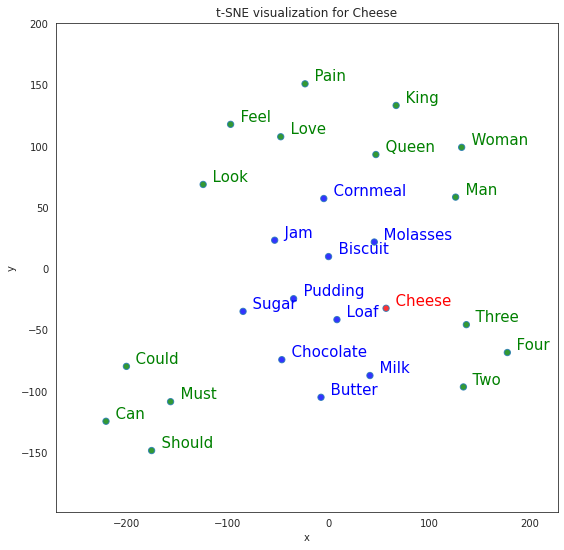

In [ ]:
import pandas as pd
import seaborn as sns

tsnescatterplot(model32_u, 32, 'cheese', ['king', 'queen', 'man', 'woman', 'feel', 'love', 'pain', 'two', 'three', 'four', 'should', 'could', 'must', 'can', 'look'])

In [ ]:
np.asarray(model32_u.vectors).shape

(103129, 32)

In [ ]:
X = model32_u.wv[vocab]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
vocab.index('can'), vocab.index('water')

(71, 280)

In [ ]:
vocab

['nevertheless',
 'guard',
 'sand',
 'front',
 'hurried',
 'old',
 'completely',
 'somebody',
 'months',
 'bob',
 'accept',
 'process',
 'leading',
 'behind',
 'where',
 'invited',
 'charming',
 'gradually',
 'member',
 'king',
 'notion',
 'realized',
 'treated',
 'simply',
 'answer',
 'arranged',
 'sentiment',
 'pipe',
 'must',
 'together',
 'going',
 'hurt',
 'island',
 'woman',
 'voice',
 'friendship',
 'ever',
 'falling',
 'except',
 'gloomy',
 'queen',
 'path',
 'pounds',
 'leaves',
 'york',
 'bless',
 'stranger',
 'train',
 'rush',
 'ignorance',
 'green',
 'correct',
 'aspect',
 'man',
 'excellent',
 'human',
 'raising',
 'gentleman',
 'should',
 'wave',
 'met',
 'lines',
 'hungry',
 'church',
 'remarkable',
 'accepted',
 'duke',
 'contempt',
 'hearing',
 'rabbit',
 'can',
 'bride',
 'isabel',
 'forward',
 'happiness',
 'cheer',
 'lucky',
 'lawyer',
 'tail',
 'listened',
 'playing',
 'thin',
 'fight',
 'delightful',
 'through',
 'century',
 'feel',
 'decision',
 'riding']

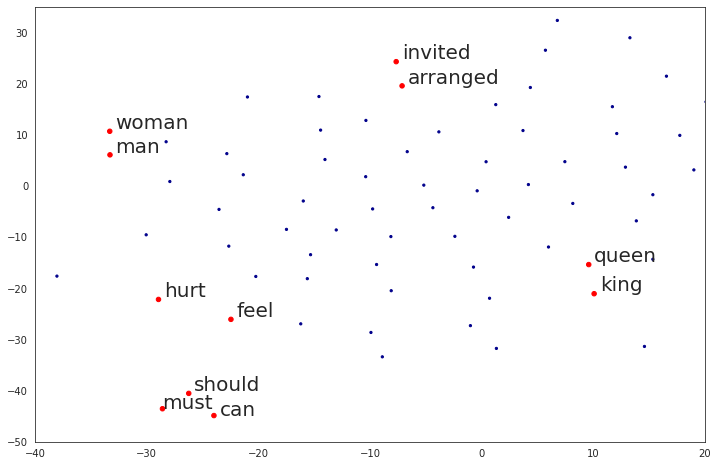

In [ ]:
SPECIAL_wORDS = ['king', 'queen', 'man', 'woman', 'can', 'must', 'should', 'feel', 'hurt', 'invited', 'arranged']
# vocab = random.sample(list(model32_u.index2entity)[:3000], 80)
# vocab = list(set(vocab) | set(SPECIAL_wORDS))
# X = model32_u.wv[vocab]

# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X)
# sns.set_style("white")

# df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

cols = ['darkblue'] * len(X_tsne)
sz = [5] * len(X_tsne)
for spec in SPECIAL_wORDS:
    cols[vocab.index(spec)] = 'red'
    sz[vocab.index(spec)] = 20

ax.scatter(df['x'], df['y'], c=cols, s=sz)

SIZE = 20


ax.annotate('king', X_tsne[vocab.index('king')], size=SIZE, xytext=X_tsne[vocab.index('king')] + np.asarray([0.5, 0.5]))
ax.annotate('queen', X_tsne[vocab.index('queen')], size=SIZE, xytext=X_tsne[vocab.index('queen')] + np.asarray([0.5, 0.5]))

ax.annotate('invited', X_tsne[vocab.index('invited')], size=SIZE, xytext=X_tsne[vocab.index('invited')] + np.asarray([0.5, 0.5]))
ax.annotate('arranged', X_tsne[vocab.index('arranged')], size=SIZE, xytext=X_tsne[vocab.index('arranged')] + np.asarray([0.5, 0.5]))

ax.annotate('man', X_tsne[vocab.index('man')], size=SIZE, xytext=X_tsne[vocab.index('man')] + np.asarray([0.5, 0.5]))
ax.annotate('woman', X_tsne[vocab.index('woman')], size=SIZE, xytext=X_tsne[vocab.index('woman')] + np.asarray([0.5, 0.5]))

# ax.annotate('brother', X_tsne[vocab.index('brother')], size=20)
# ax.annotate('sister', X_tsne[vocab.index('sister')], size=20)

ax.annotate('can', X_tsne[vocab.index('can')], size=SIZE, xytext=X_tsne[vocab.index('can')] + np.asarray([0.5, 0]))
# ax.annotate('could', X_tsne[vocab.index('could')], size=20)
ax.annotate('must', X_tsne[vocab.index('must')], size=SIZE)
ax.annotate('should', X_tsne[vocab.index('should')], size=SIZE, xytext=X_tsne[vocab.index('should')] + np.asarray([0.5, 0.5]))

ax.annotate('feel', X_tsne[vocab.index('feel')], size=SIZE, xytext=X_tsne[vocab.index('feel')] + np.asarray([0.5, 0.5]))
ax.annotate('hurt', X_tsne[vocab.index('hurt')], size=SIZE, xytext=X_tsne[vocab.index('hurt')] + np.asarray([0.5, 0.5]))


# ax.annotate('cheese', X_tsne[vocab.index('cheese')], size=20)
# ax.annotate('wine', X_tsne[vocab.index('wine')], size=20)
for word, pos in df.iterrows():
    if random.randint(0, 1) == 0 and False:
        ax.annotate(word, pos)

plt.xlim(-40, 20)
plt.ylim(-50, 35)

# plt.title('Проекции векторов CBOW', size=20)
plt.show()

In [ ]:
df.to_csv('drive/MyDrive/Coursework2021/cbow/plots/vectors32_i.csv')

In [ ]:
fig.savefig('drive/MyDrive/Coursework2021/cbow/plots/vectors32_u1.png')

# Кластеризую для модели $32$

In [ ]:
model32_u = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size32_unnormed.kv')